<a href="https://colab.research.google.com/github/Khanbir/Projekt_Otis/blob/main/final_projekt_Khanbir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

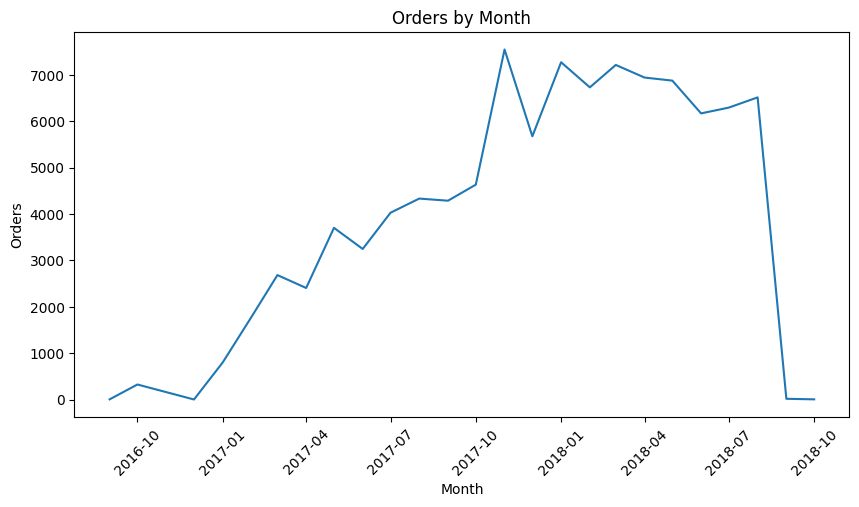

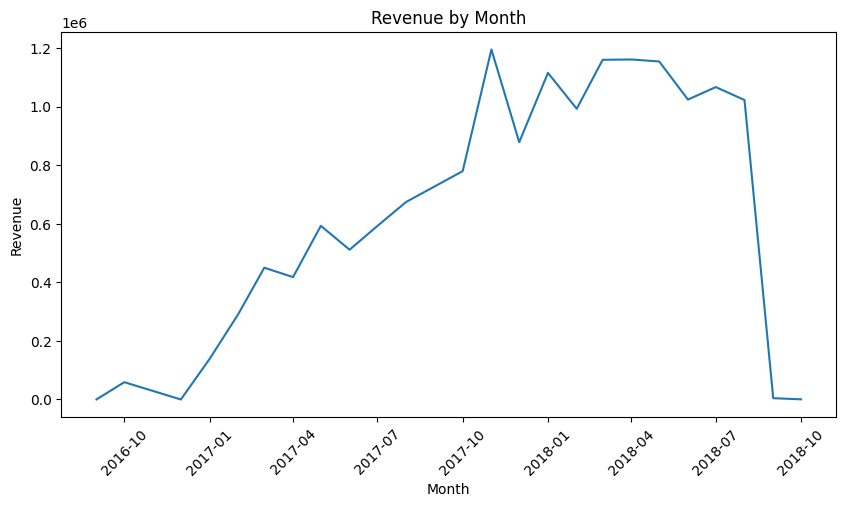

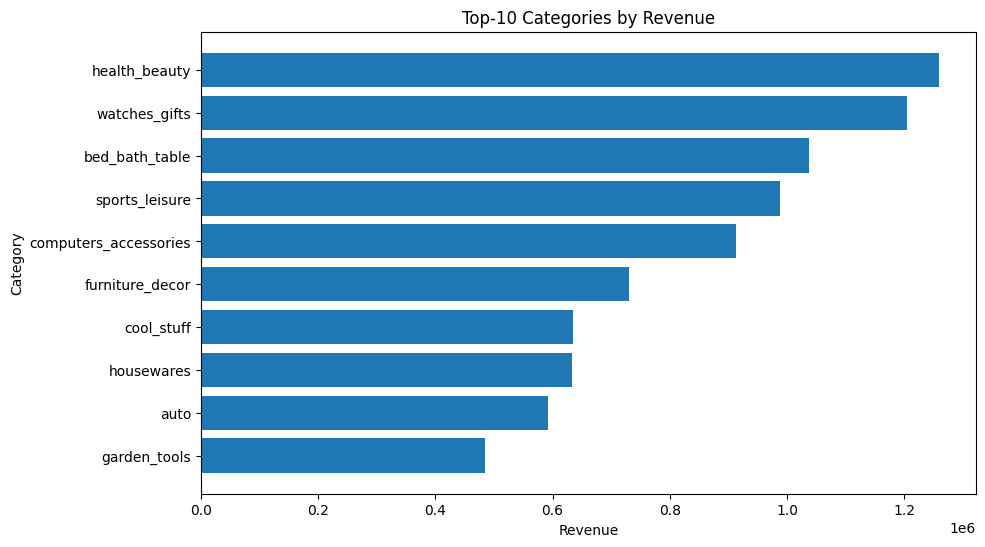

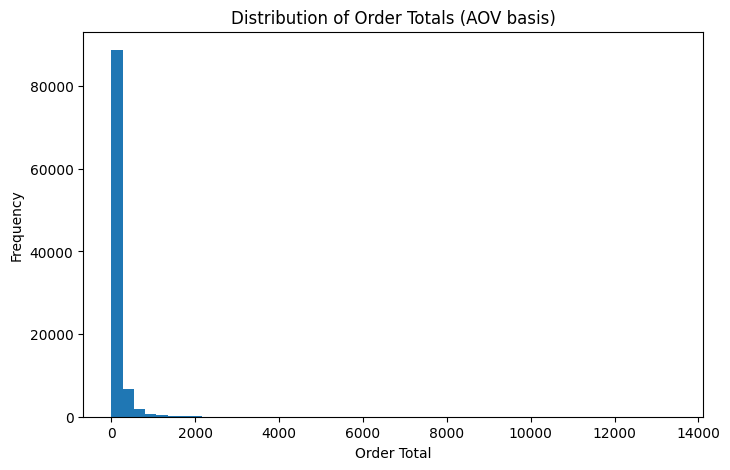

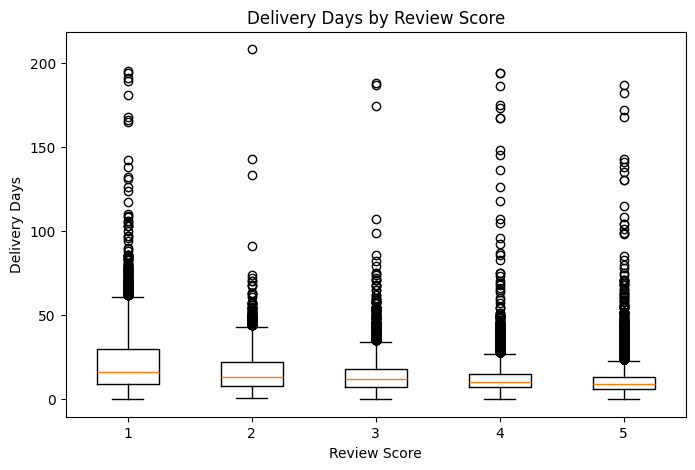

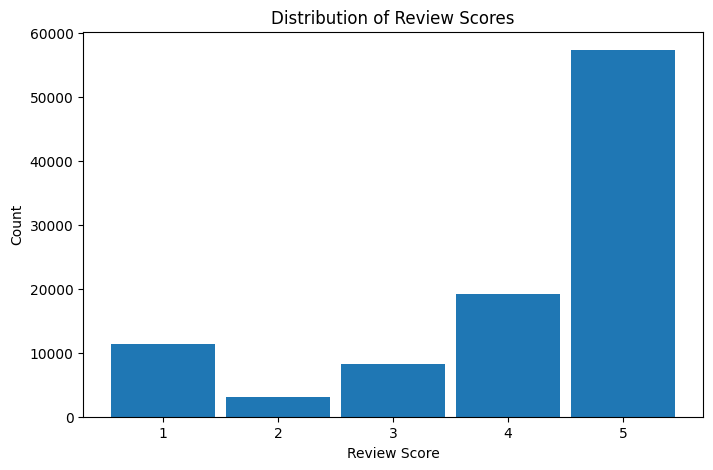

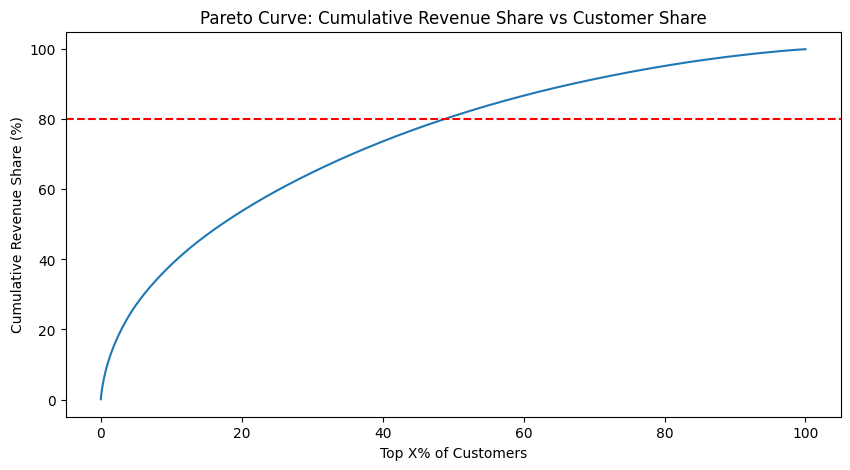

                             Metric        Value
0                     Total Revenue  16008872.12
1         Average Order Value (AOV)       137.75
2                Retention Rate (%)         3.12
3             Average Delivery Days        12.09
4  Pareto Share (Top 20% customers)        53.77


In [1]:
# =======================
# Olist Dataset Analysis (Python -> Tableau Pipeline)
# =======================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1) DATA PREPARATION ---

# Load CSVs (заміни шляхи на свої локальні, якщо треба)
files = {
    "orders": "/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_orders_dataset.csv",
    "order_items": "/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_order_items_dataset.csv",
    "order_payments": "/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_order_payments_dataset.csv",
    "order_reviews": "/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_order_reviews_dataset.csv",
    "customers": "/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_customers_dataset.csv",
    "sellers": "/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_sellers_dataset.csv",
    "products": "/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_products_dataset.csv",
    "geolocation": "/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_geolocation_dataset.csv",
    "category_translation": "/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/product_category_name_translation.csv"
}
dfs = {name: pd.read_csv(path) for name, path in files.items()}

orders = dfs["orders"].copy()
order_items = dfs["order_items"].copy()
order_payments = dfs["order_payments"].copy()
order_reviews = dfs["order_reviews"].copy()
customers = dfs["customers"].copy()
products = dfs["products"].copy()
category_translation = dfs["category_translation"].copy()

# Convert dates
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]
for c in date_cols:
    if c in orders.columns:
        orders[c] = pd.to_datetime(orders[c], errors="coerce")

# Translate product categories
products = products.merge(
    category_translation,
    how="left",
    left_on="product_category_name",
    right_on="product_category_name"
)
products["product_category_name"] = (
    products["product_category_name_english"]
    .fillna(products["product_category_name"])
)
products.drop(columns=["product_category_name_english"], inplace=True, errors="ignore")

# --- 2) METRICS CALCULATION ---

# Total Revenue
total_revenue = float(order_payments["payment_value"].sum())

# AOV (Average Order Value)
order_totals = order_items.groupby("order_id", as_index=False)["price"].sum()
aov = float(order_totals["price"].mean())

# Orders trend by month
orders["month_period"] = orders["order_purchase_timestamp"].dt.to_period("M")
orders["month_dt"] = orders["month_period"].dt.to_timestamp()
orders_monthly = (
    orders.groupby("month_dt", as_index=False)["order_id"]
    .nunique()
    .rename(columns={"order_id": "total_orders"})
)

# Revenue trend by month
orders_revenue = (
    orders.merge(order_payments, on="order_id")
    .groupby("month_dt", as_index=False)["payment_value"]
    .sum()
    .rename(columns={"payment_value": "revenue"})
)

# Monthly summary
monthly_summary = orders_monthly.merge(orders_revenue, on="month_dt", how="left")
monthly_summary["aov"] = monthly_summary["revenue"] / monthly_summary["total_orders"]

# Retention (share of repeat customers)
orders_customers = orders.merge(customers, on="customer_id", how="left")
cust_orders = (
    orders_customers.groupby("customer_unique_id", as_index=False)["order_id"]
    .nunique()
    .rename(columns={"order_id": "orders_count"})
)
repeat_customers = int((cust_orders["orders_count"] > 1).sum())
total_customers = int(cust_orders.shape[0])
retention_rate = float(repeat_customers / total_customers * 100.0)

# Top-10 categories by revenue
revenue_by_category = (
    order_items.merge(products[["product_id", "product_category_name"]], on="product_id", how="left")
    .groupby("product_category_name", as_index=False)["price"].sum()
    .rename(columns={"price": "revenue"})
    .sort_values("revenue", ascending=False)
    .head(10)
)

# Payment methods share
payments_summary = (
    order_payments.groupby("payment_type", as_index=False)
    .agg(total_payments=('payment_value', 'count'), total_value=('payment_value', 'sum'))
    .sort_values("total_value", ascending=False)
)

# Average delivery days
orders["delivery_days"] = (
    orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]
).dt.days
avg_delivery_days = float(orders["delivery_days"].dropna().mean())

# Delivery vs Review Score
reviews_with_delivery = order_reviews.merge(
    orders[["order_id", "delivery_days"]], on="order_id", how="inner"
)
delivery_vs_reviews = (
    reviews_with_delivery.groupby("review_score", as_index=False)["delivery_days"].mean()
    .rename(columns={"delivery_days": "avg_delivery_days"})
    .sort_values("review_score")
)

# Pareto (20% customers -> % revenue)
customer_revenue = (
    customers.merge(orders[["order_id", "customer_id"]], on="customer_id", how="inner")
    .merge(order_payments[["order_id", "payment_value"]], on="order_id", how="inner")
    .groupby("customer_unique_id", as_index=False)["payment_value"].sum()
    .rename(columns={"payment_value": "total_spent"})
    .sort_values("total_spent", ascending=False)
    .reset_index(drop=True)
)
customer_revenue["cum_revenue"] = customer_revenue["total_spent"].cumsum()
customer_revenue["cum_revenue_share"] = (
    customer_revenue["cum_revenue"] / customer_revenue["total_spent"].sum() * 100.0
)
top_20_cut = int(np.ceil(0.2 * len(customer_revenue)))
pareto_share = float(
    customer_revenue.loc[: top_20_cut - 1, "total_spent"].sum()
    / customer_revenue["total_spent"].sum()
    * 100.0
)

# --- 3) EDA VISUALIZATIONS (matplotlib) ---

# Orders by month
plt.figure(figsize=(10, 5))
plt.plot(monthly_summary["month_dt"], monthly_summary["total_orders"])
plt.title("Orders by Month")
plt.xlabel("Month")
plt.ylabel("Orders")
plt.xticks(rotation=45)
plt.show()

# Revenue by month
plt.figure(figsize=(10, 5))
plt.plot(monthly_summary["month_dt"], monthly_summary["revenue"])
plt.title("Revenue by Month")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()

# Top-10 categories by revenue
plt.figure(figsize=(10, 6))
plt.barh(revenue_by_category["product_category_name"][::-1], revenue_by_category["revenue"][::-1])
plt.title("Top-10 Categories by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Category")
plt.show()

# Histogram: AOV
plt.figure(figsize=(8, 5))
plt.hist(order_totals["price"], bins=50)
plt.title("Distribution of Order Totals (AOV basis)")
plt.xlabel("Order Total")
plt.ylabel("Frequency")
plt.show()

# Boxplot: Delivery days vs Review score
scores_sorted = sorted(reviews_with_delivery["review_score"].dropna().unique())
box_data = [
    reviews_with_delivery.loc[reviews_with_delivery["review_score"] == s, "delivery_days"].dropna().values
    for s in scores_sorted
]
plt.figure(figsize=(8, 5))
plt.boxplot(box_data, tick_labels=scores_sorted)
plt.title("Delivery Days by Review Score")
plt.xlabel("Review Score")
plt.ylabel("Delivery Days")
plt.show()

# Histogram: Ratings distribution
plt.figure(figsize=(8, 5))
plt.hist(order_reviews["review_score"].dropna(), bins=[0.5,1.5,2.5,3.5,4.5,5.5], rwidth=0.9)
plt.title("Distribution of Review Scores")
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.show()

# Pareto curve
plt.figure(figsize=(10, 5))
x_vals = np.arange(1, len(customer_revenue) + 1)
x_share = x_vals / len(customer_revenue) * 100.0
plt.plot(x_share, customer_revenue["cum_revenue_share"])
plt.axhline(80, linestyle="--", color="red")
plt.title("Pareto Curve: Cumulative Revenue Share vs Customer Share")
plt.xlabel("Top X% of Customers")
plt.ylabel("Cumulative Revenue Share (%)")
plt.show()

# --- 4) EXPORT TABLES FOR TABLEAU ---

monthly_summary_out = monthly_summary.rename(columns={"month_dt": "month"})
monthly_summary_out.to_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/orders_monthly.csv", index=False)

categories_out = revenue_by_category.rename(columns={"product_category_name": "category"})
categories_out.to_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/categories_revenue.csv", index=False)

cust_retention_out = cust_orders.rename(columns={"orders_count": "orders_per_customer"})
cust_retention_out.to_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/customers_retention.csv", index=False)

delivery_vs_reviews.to_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/delivery_reviews.csv", index=False)
payments_summary.to_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/payments_summary.csv", index=False)
customer_revenue.to_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/pareto_customers.csv", index=False)

# --- Summary metrics table ---
summary_metrics = pd.DataFrame({
    "Metric": [
        "Total Revenue",
        "Average Order Value (AOV)",
        "Retention Rate (%)",
        "Average Delivery Days",
        "Pareto Share (Top 20% customers)"
    ],
    "Value": [
        round(total_revenue, 2),
        round(aov, 2),
        round(retention_rate, 2),
        round(avg_delivery_days, 2),
        round(pareto_share, 2)
    ]
})
print(summary_metrics)